In [1]:
import numpy as np
import pandas as pd
import os

## Загрузка библиотек и данных

In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
!wget 'https://drive.google.com/file/d/1Zn-pvadHWD3Z77x17cDacN4W-V1WvNVk/view?usp=drive_link' -O leapgestrecog.zip

--2023-09-17 14:18:40--  https://drive.google.com/file/d/1Zn-pvadHWD3Z77x17cDacN4W-V1WvNVk/view?usp=drive_link
Resolving drive.google.com (drive.google.com)... 74.125.130.139, 74.125.130.101, 74.125.130.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.130.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘leapgestrecog.zip’

leapgestrecog.zip       [ <=>                ]  78.70K  --.-KB/s    in 0.03s   

2023-09-17 14:18:41 (2.93 MB/s) - ‘leapgestrecog.zip’ saved [80585]



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/HandGestureRecognitionDatabase.zip", 'r')
zip_ref.extractall("/content/leapgestrecog")
zip_ref.close()

In [7]:
def Create_Directory_DataFrame():
    df = pd.DataFrame(columns=['Class','Path'])
    basedir = '/content/leapgestrecog/leapGestRecog/'
    for folder in os.listdir(basedir):
        for Class in os.listdir(basedir+folder+'/'):
            for location in os.listdir(basedir+folder+'/'+Class+'/'):
                df = df.append({'Class':Class,'Path':basedir+folder+'/'+Class+'/'+location},ignore_index=True)
    df = df.sample(frac = 1)
    return df

In [8]:
df = Create_Directory_DataFrame()
print(df.shape)
df.head()

(20000, 2)


,Class,Path
3521,08_palm_moved,/content/leapgestrecog/leapGestRecog/00/08_pal...
14924,06_index,/content/leapgestrecog/leapGestRecog/04/06_ind...
16630,09_c,/content/leapgestrecog/leapGestRecog/05/09_c/f...
18040,03_fist,/content/leapgestrecog/leapGestRecog/06/03_fis...
14001,03_fist,/content/leapgestrecog/leapGestRecog/04/03_fis...


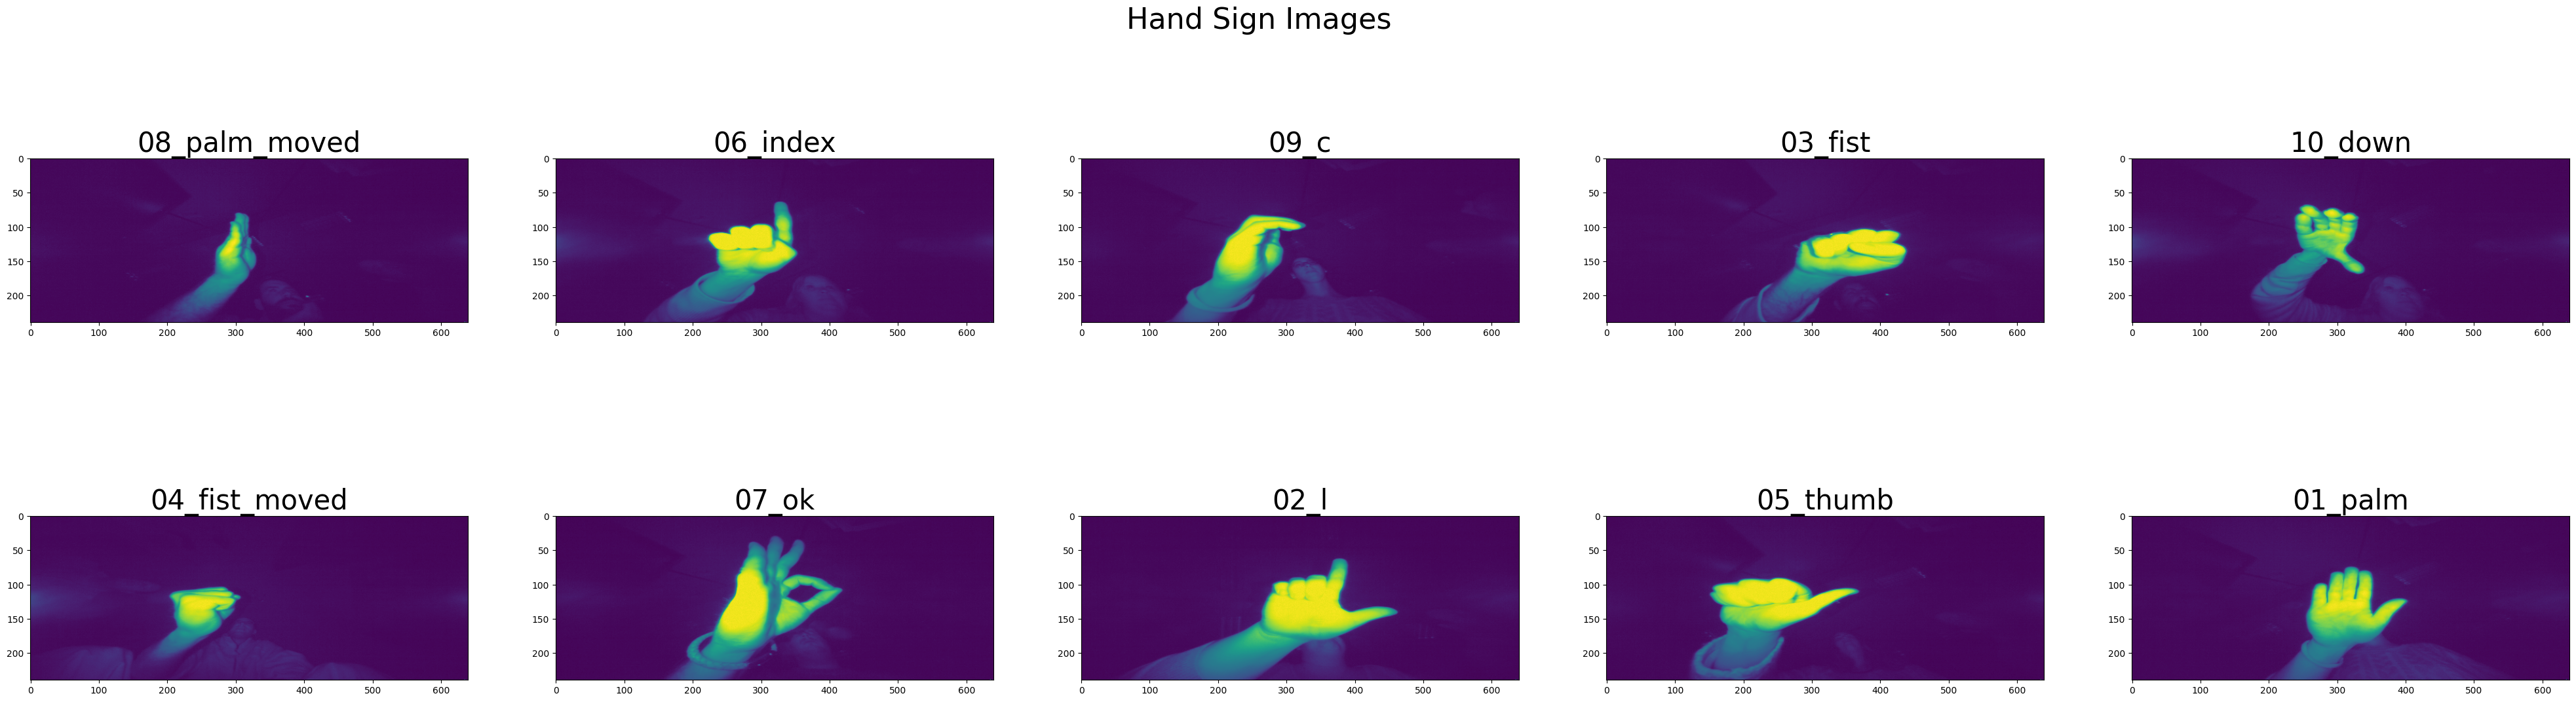

In [9]:
import cv2
count = 1
f = plt.figure(figsize=(50,13))
for Class in df['Class'].unique():
    seg = df[df['Class']==Class]
    address = seg.sample().iloc[0]['Path']
    img = cv2.imread(address,0)
    ax = f.add_subplot(2, 5, count)
    ax = plt.imshow(img)
    ax = plt.title(Class,fontsize= 30)
    count = count + 1
plt.suptitle("Hand Sign Images", size = 32)
plt.show()

In [10]:
img.shape

(240, 640)

In [11]:
# классы жестов:

df['Class'].value_counts()

08_palm_moved    2000
06_index         2000
09_c             2000
03_fist          2000
10_down          2000
04_fist_moved    2000
07_ok            2000
02_l             2000
05_thumb         2000
01_palm          2000
Name: Class, dtype: int64

In [12]:
class GestDataset(torch.utils.data.Dataset):

    def __init__(self, dataframe: pd.DataFrame, label2indx,
                 transformer, img_column: str = 'Path', label_column: str = 'Class'):
        super().__init__()
        self.transformer = transformer
        self.dataframe = dataframe
        self.img_column = img_column
        self.label_column = label_column
        self.label2indx = label2indx
        self.indx2label = {indx: label for label, indx in self.label2indx.items()}


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, indx):
        image = cv2.imread(self.dataframe.iloc[indx][self.img_column])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, -1).repeat(3, -1)  #expend dimention to use pretrained model
        image = image / 255
        image = image.astype('float32')

        label = self.dataframe.iloc[indx][self.label_column]

        if self.transformer:
            sample = self.transformer(image=image)['image']

        return torchvision.transforms.ToTensor()(sample.astype('float32')), self.label2indx[label]

In [13]:
#Разделение на обучение и тест

from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.25, shuffle=True, stratify=df['Class'])
train_df.head(2)

,Class,Path
10628,09_c,/content/leapgestrecog/leapGestRecog/03/09_c/f...
7773,07_ok,/content/leapgestrecog/leapGestRecog/07/07_ok/...


In [14]:
#Создадим объекты для необходимых трансформаций нашего датасета, а также сам dataset и обернем его в dataloader

import albumentations as alb

train_transformer = alb.Compose([
    alb.Resize(height=256, width=256),
    alb.RandomCrop(height=224, width=224),
    alb.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.5, rotate_limit=10, p=1, border_mode=cv2.BORDER_CONSTANT),
    alb.ColorJitter (brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, always_apply=True),
    alb.RandomGamma()
])

running_trainsformer = alb.Compose([
    alb.Resize(height=224, width=224)
])

LABEL2INDX = {label: int(label.split('_')[0]) - 1 for label in df['Class'].unique()}

train_dataset = GestDataset(dataframe=train_df, transformer=train_transformer, label2indx=LABEL2INDX)
train_loader = torch.utils.data.dataloader.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

valid_dataset = GestDataset(dataframe=valid_df, transformer=running_trainsformer, label2indx=LABEL2INDX)
valid_loader = torch.utils.data.dataloader.DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

Size torch.Size([3, 224, 224])


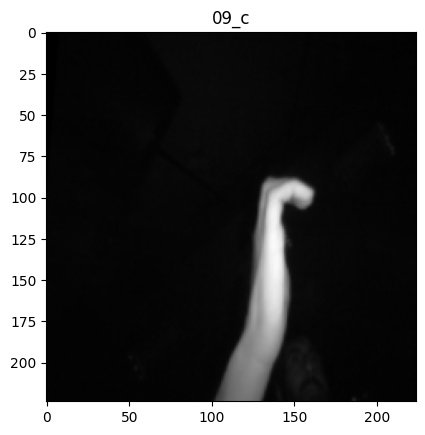

In [15]:
for img, label in train_dataset:
    print('Size', img.shape)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(train_dataset.indx2label[label])
    plt.show()
    break

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 224, 224])


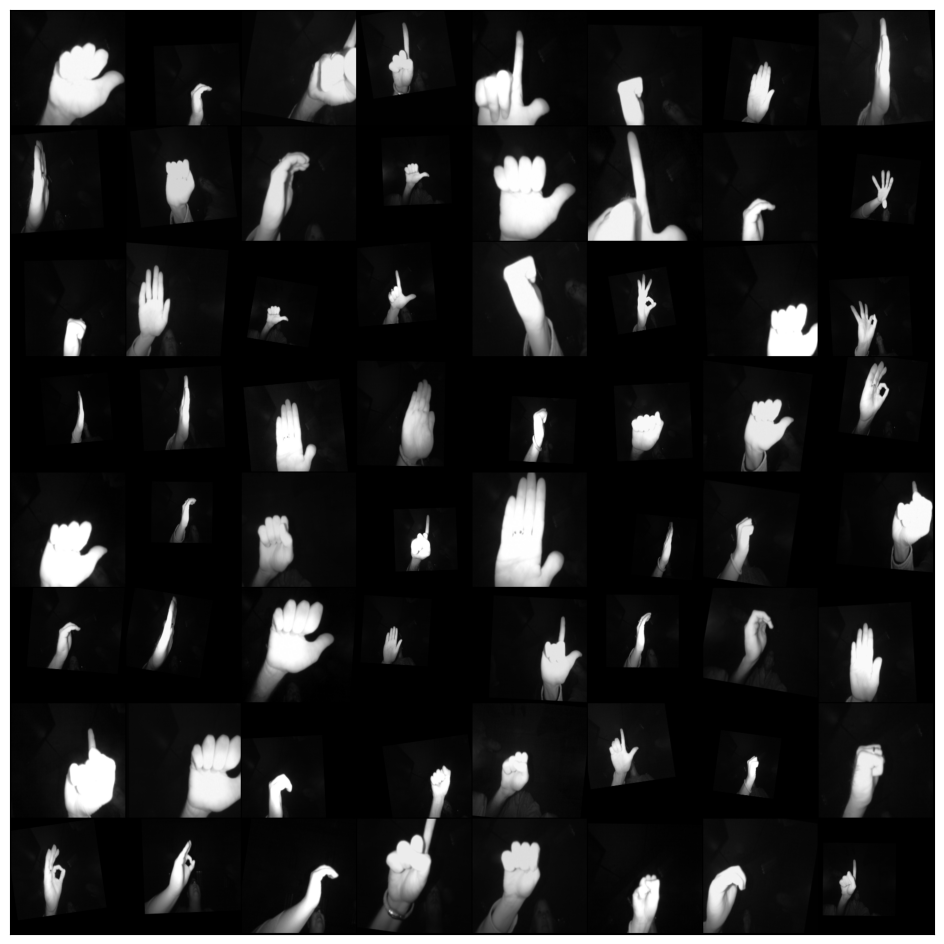

In [18]:
show_batch(train_loader)

In [19]:
!pip install torchsummary

from torchvision import models
from torchsummary import summary

## Построение и обучение модели

In [20]:
from time import time
from tqdm import tqdm
import tqdm.notebook as tq

def train(model, criterion, optimizer, train_dataloader, test_dataloader, print_every, num_epoch):

    steps = 0
    train_losses, val_losses = [], []


    model.to(device)
    for epoch in tq.tqdm(range(num_epoch), desc='epoch',position=0):
        running_loss = 0
        correct_train = 0
        total_train = 0

        model.train()
        for i, (images, labels) in tq.tqdm(enumerate(train_dataloader),
                                        desc='Progress',
                                        total=len(train_dataloader),
                                        position=1):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)

    return model, train_losses, val_losses

In [21]:
class GestRecogBlock(torch.nn.Module):
    def __init__(self, in_features, out_features, kernel_size=(3, 3), pool_size=2, drop_out=0.3):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=in_features,
                              out_channels=int(out_features / 2),
                              kernel_size=kernel_size, padding='same')

        self.conv_2 = nn.Conv2d(in_channels=int(out_features / 2),
                              out_channels=out_features,
                              kernel_size=kernel_size, padding='same')

        torch.nn.init.kaiming_normal_(self.conv_1.weight)
        torch.nn.init.kaiming_normal_(self.conv_2.weight)

        self.max_pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        self.bn = nn.BatchNorm2d(num_features=out_features)
        self.drop_out = nn.Dropout2d(drop_out)


    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.bn(x)
        x = self.max_pool(x)
        return x

class GestRecogNN(torch.nn.Module):
    def get_dense_block(self, input_features, out_features, p_dropout):
        return nn.Sequential(
            nn.Linear(input_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Dropout(p_dropout)
        )

    def __init__(self, in_features, out_features):
        super().__init__()
        self.base_block = GestRecogBlock(in_features=in_features, out_features=64)
        self.base_block_2 = GestRecogBlock(in_features=64, out_features=128)
        self.base_block_3 = GestRecogBlock(in_features=128, out_features=256)
        self.base_block_4 = GestRecogBlock(in_features=256, out_features=512)
        self.classifier = nn.Sequential(
            self.get_dense_block(input_features=100352, out_features=256, p_dropout=0.2),
            self.get_dense_block(input_features=256, out_features=128, p_dropout=0.2),
            nn.Linear(in_features=128, out_features=out_features),
            nn.ReLU())

    def forward(self, x):
        x = self.base_block(x)
        x = self.base_block_2(x)
        x = self.base_block_3(x)
        x = self.base_block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [22]:
model = GestRecogNN(in_features=3, out_features=10).to(device)

model, train_losses, val_losses = train(
    model=model,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    print_every=100,
    num_epoch=5
)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Progress:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [1]/[5]. Batch [100]/[235]. Train loss 1.912. Train acc 35.109. Val loss 1.466. Val acc 48.520. Epoch [1]/[5]. Batch [200]/[235]. Train loss 1.782. Train acc 40.445. Val loss 1.020. Val acc 65.500. 

Progress:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [2]/[5]. Batch [65]/[235]. Train loss 0.252. Train acc 68.918. Val loss 0.730. Val acc 83.460. Epoch [2]/[5]. Batch [165]/[235]. Train loss 0.357. Train acc 75.104. Val loss 0.347. Val acc 88.620. 

Progress:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [3]/[5]. Batch [30]/[235]. Train loss 0.053. Train acc 78.281. Val loss 0.545. Val acc 87.500. Epoch [3]/[5]. Batch [130]/[235]. Train loss 0.128. Train acc 82.945. Val loss 0.303. Val acc 88.640. Epoch [3]/[5]. Batch [230]/[235]. Train loss 0.172. Train acc 83.954. Val loss 0.342. Val acc 88.160. 

Progress:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [4]/[5]. Batch [95]/[235]. Train loss 0.083. Train acc 81.250. Val loss 0.372. Val acc 89.420. Epoch [4]/[5]. Batch [195]/[235]. Train loss 0.119. Train acc 84.006. Val loss 0.295. Val acc 89.100. 

Progress:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [5]/[5]. Batch [60]/[235]. Train loss 0.035. Train acc 83.516. Val loss 0.335. Val acc 89.440. Epoch [5]/[5]. Batch [160]/[235]. Train loss 0.066. Train acc 85.693. Val loss 0.297. Val acc 89.180. 

In [23]:
# сохраняем модель

torch.save(model, 'final_model')

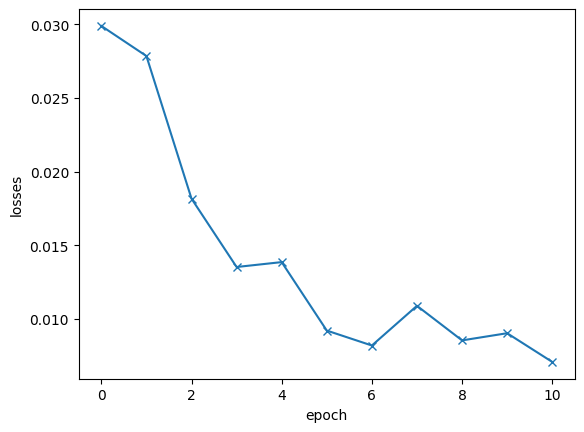

In [24]:
# Посмотрим на нашу ошибку в процессе обучения:
losses = [np.mean(loss) for loss in train_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

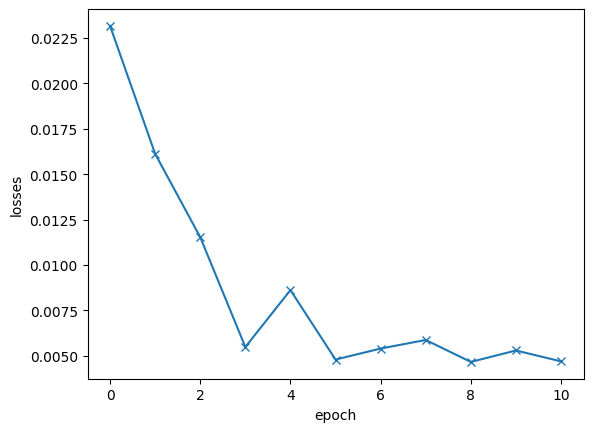

In [25]:
# Посмотрим на нашу ошибку в процессе валидации:
losses = [np.mean(loss) for loss in val_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

In [26]:
net = torch.load('final_model')
net.eval()

GestRecogNN(
  (base_block): GestRecogBlock(
    (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_out): Dropout2d(p=0.3, inplace=False)
  )
  (base_block_2): GestRecogBlock(
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_out): Dropout2d(p=0.3, inplace=False)
  )
  (base_block_3): GestRecogBlock(
    (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv_2): Conv2d(128, 25

In [27]:
valid_df.head(3)

,Class,Path
4834,06_index,/content/leapgestrecog/leapGestRecog/01/06_ind...
11952,01_palm,/content/leapgestrecog/leapGestRecog/03/01_pal...
9106,02_l,/content/leapgestrecog/leapGestRecog/09/02_l/f...


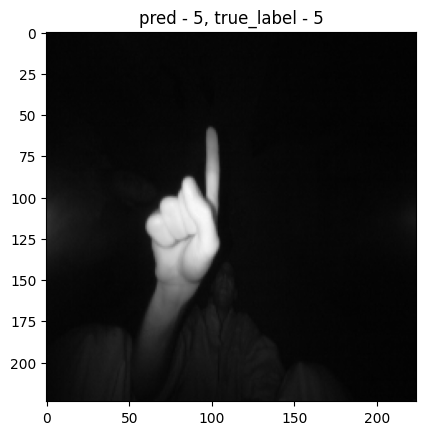

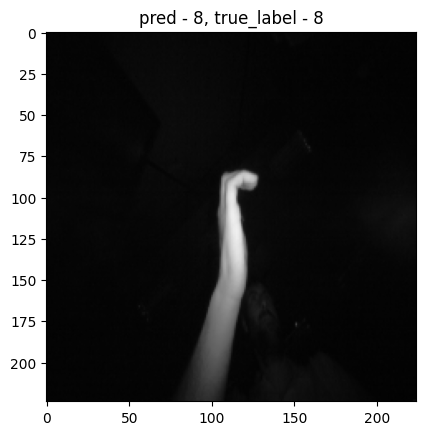

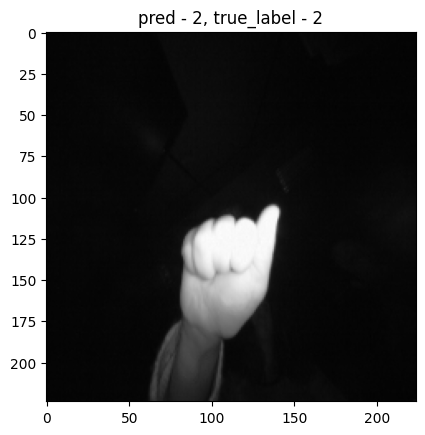

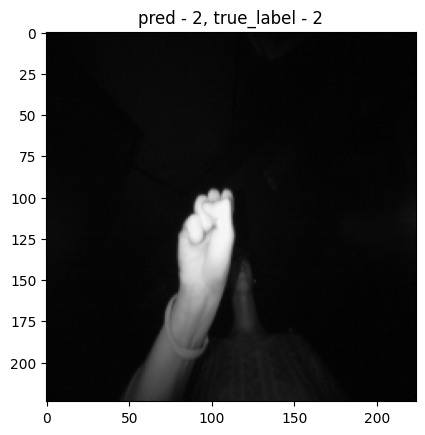

In [28]:
#Прогоним нашу нейронную сеть через тестовый датасет:

with torch.no_grad():
    for i, data in enumerate(valid_loader, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        plt.title(f'pred - {(outputs[0].argmax())}, true_label - {(labels[0])}')
        plt.imshow(images[0].permute(1, 2, 0).cpu().squeeze(), cmap='gray')
        plt.show()
        if i>5:
            break

Как видно по тестовым изображениям, модель ни разу не ошиблась.Обученная модель на распознавание жестов имеет точность на валидации Val acc 89.180.


## Пайплайн для распознавания жестов на изображении при обнаружении лица на кадре

In [29]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.8 MB/s eta 0:00:00


In [31]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN


class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.emodel = torch.load('final_model')
        self.emodel.eval()

    def _draw(self, frame, boxes, probs, landmarks, emotions):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for box, prob, ld, emotion in zip(boxes, probs, landmarks, emotions):
                # Draw rectangle on frame
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # Show probability
                cv2.putText(frame,
                    emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Draw landmarks
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            pass

        return frame

    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            # plt.imshow(frame[int(box[1]):int(box[3]), int(box[0]):int(box[2])])
            # plt.show()
            faces.append(frame[int(box[1]):int(box[3]),
                int(box[0]):int(box[2])])
        return faces


    def run(self, path_to_img):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """
        frame = cv2.imread(path_to_img)


        # detect face box, probability and landmarks
        boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
        print(boxes)

        faces = self.crop_faces(frame, boxes)
        gestures = []
        for face in faces:
            face = cv2.resize(face,(48,48))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

            torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
            gesture = self.emodel(torch_face[None, ...])
            gesture = self.gesture.argmax()
            gestures.append(gesture)

        # draw on frame
        self._draw(frame, boxes, probs, landmarks, gestures)

        # Show the frame
        cv2.imwrite('Face_Detection.png', frame)
        plt.figure(figsize=(20, 10))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.show()


# Run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)